# NTSB Data Analysis
Exploratory Data Analysis and Answering Questions

## Importing Libraries, Importing Data

In [1]:
# Import libraries as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Find local data files and print their paths.

for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/AviationData.csv
./data/USState_Codes.csv


In [3]:
# Read the csv into a pandas dataframe

avdata = pd.read_csv('./data/AviationData.csv', encoding='latin1')
avdata.head()

/var/folders/4l/6c222s892fg67l2z22tx7lrw0000gn/T/ipykernel_95950/3677350135.py:3: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  avdata = pd.read_csv('./data/AviationData.csv', encoding='latin1')


,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


## Exploratory Data Analysis

Now that the data has been imported, let's try to understand it.

In [4]:
# See what the columns of the dataframe are

avdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

At a glance through the columns, some preliminary questions about the data arise.

- What are the purposes of accidents operating under Part 91 vs Commercially?
- Do accidents change over time? Frequency, reason, # deaths
- During what phase of flight do most accidents occur? (part 91 vs commercial)
- VMC or IMC for 91/commercial?
- Should we remove helicopters from the dataset?

In [5]:
# Let's see where there is missing data

avdata.isnull().sum()

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38757
Airport.Name              36185
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1382
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7096
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6384
Publication.Date          13771
dtype: i

In [6]:
# Create a dataframe that I can edit and change without modifying the original

df = avdata.copy()

### Data Cleaning

Because this is a very large dataset, I think the best way to go about this is to pull columns into a new dataframe every time i need specific information to graph.

List of operations in data cleaning section:
- Standardize FAR.Description
- Include a new Year column in the df

In [7]:
df['FAR.Description'].value_counts()

FAR.Description
091                               18221
Part 91: General Aviation          6486
NUSN                               1584
NUSC                               1013
137                                1010
135                                 746
121                                 679
Part 137: Agricultural              437
UNK                                 371
Part 135: Air Taxi & Commuter       298
PUBU                                253
129                                 246
Part 121: Air Carrier               165
133                                 107
Part 129: Foreign                   100
Non-U.S., Non-Commercial             97
Non-U.S., Commercial                 93
Part 133: Rotorcraft Ext. Load       32
Unknown                              22
Public Use                           19
091K                                 14
ARMF                                  8
Part 125: 20+ Pax,6000+ lbs           5
125                                   5
107                     

In [8]:
def standardize_far_parts(df):
    """
    Part under which flight is operating represented in a few different ways
    This function standardizes that data
    
    params: 
        df (pandas DataFrame): dataframe containing FAR.Description column
        
    returns:
        (pandas DataFrame): dataframe with cleaned info
    """
    
    df_clean = df.copy()
    
    patterns = {
        r'^091$': '91',
        r'^Part 91: General Aviation$': '91',
        r'^Part 121: Air Carrier$': '121',
        r'^Part 135: Air Taxi & Commuter$': '135'
    }
    
    df_clean['FAR.Description'] = df_clean['FAR.Description'].replace(patterns, regex=True)
    
    return df_clean


In [9]:
# Use the standardize function!

df = standardize_far_parts(df)

In [10]:
# Add a Year column

df['Year'] = pd.to_datetime(df['Event.Date']).dt.year

### Graph some variables

List of graphs:
- Accidents per year

In [11]:
# Created a new df grouping years together and counting the number of entries per year.

df_year_acc = df.groupby('Year').size().reset_index(name='Accidents')


In [12]:
# There are only a few entries in the years below 1982. Let's strip those so the data is cleaner

df_year_acc = df_year_acc[df_year_acc['Year'] > 1981]

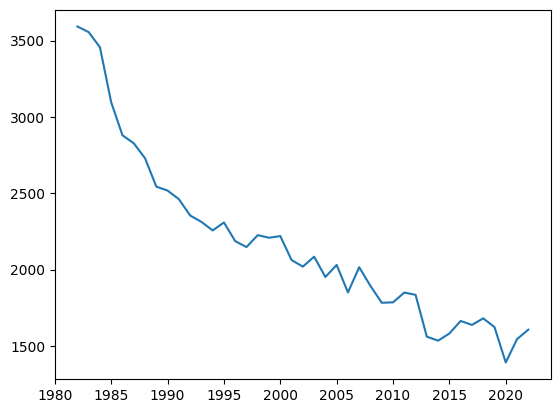

In [13]:
plt.plot(df_year_acc["Year"], df_year_acc["Accidents"])
plt.show()